# Sprawozdanie z Laboratorium 2  
## Autorzy: Mateusz Pawliczek, Piotr Świerzy  
## Data: 18.03.25  

## Zadanie 1  

Celem zadania jest zastosowanie metody najmniejszych kwadratów do predykcji, czy nowotwór jest złośliwy (ang. *malignant*), czy łagodny (ang. *benign*).  
Nowotwory złośliwe i łagodne różnią się charakterystyką wzrostu. Istotne cechy to m.in. promień i tekstura, które są wyznaczane za pomocą diagnostyki obrazowej i biopsji.  

Do rozwiązania problemu wykorzystamy bibliotekę *pandas*, typ *DataFrame* oraz dwa zbiory danych:  
- `breast-cancer-train.dat`  
- `breast-cancer-validate.dat`  

Nazwy kolumn znajdują się w pliku `breast-cancer.labels`. Pierwsza kolumna to identyfikator pacjenta (*patient ID*). Dla każdego pacjenta wartość w kolumnie *Malignant/Benign* wskazuje klasę, tj. czy nowotwór jest złośliwy, czy łagodny. Pozostałe 30 kolumn zawiera cechy, tj. charakterystyki nowotworu.

a) Na początku importujemy potrzebne nam na później biblioteki, a później otwieramy pliki i zapisujemy je jako *DataFrame*.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics import confusion_matrix

dataset_dir = os.path.join(os.getcwd(), "dataset")

columns = pd.read_csv(os.path.join(dataset_dir, "breast-cancer.labels"), header=None).squeeze().tolist()
train_data = pd.read_csv(os.path.join(dataset_dir, "breast-cancer-train.dat"), names=columns)
validate_data = pd.read_csv(os.path.join(dataset_dir, "breast-cancer-validate.dat"), names=columns)

b) Następnie rysujemy histogram, który pokazuje zależność między średnim promieniem nowotworu a liczbą wystąpień nowotworów, z rozróżnieniem na nowotwory złośliwe i łagodne.

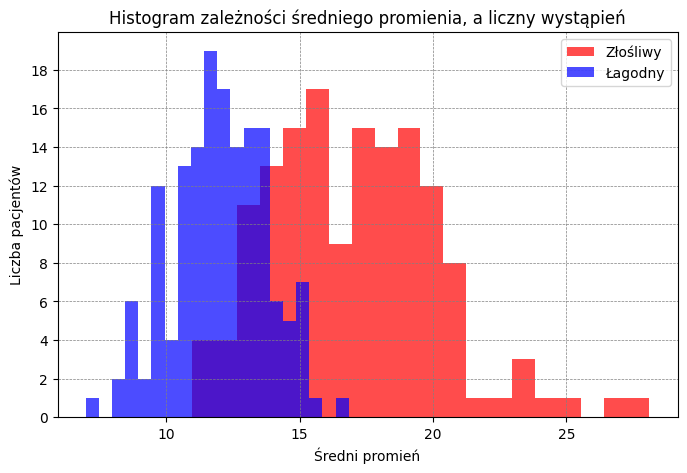

In [2]:
malignant = train_data[train_data["Malignant/Benign"] == "M"]
benign = train_data[train_data["Malignant/Benign"] == "B"]
feature = "radius (mean)"
plt.figure(figsize=(8, 5))
plt.hist(malignant[feature], bins=20, alpha=0.7, label="Złośliwy", color="red")
plt.hist(benign[feature], bins=20, alpha=0.7, label="Łagodny", color="blue")
plt.xlabel("Średni promień")
plt.ylabel("Liczba pacjentów")
plt.title("Histogram zależności średniego promienia, a liczny wystąpień")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.yticks(np.arange(0, 20, 2))
plt.show()

Widać, że zazwyczaj jeśli mamy doczynienia z większym promieniem nowotworu, okazuje się być złośliwy.

c) Kolejnym krokiem jest przygotowanie macierzy dla **liniowej** *(wszystkie 30 cech)* i **kwadratowej** *(4 cechy podane w liście `selected_features`)* metody najmniejszych kwadratów. Robimy to zarówno dla danych treningowych, jak i danych walidacyjnych.

In [3]:
selected_features = ["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]
A_training_lin = np.c_[np.ones(train_data.shape[0]), train_data.iloc[:, 2:].values]
A_validate_lin = np.c_[np.ones(validate_data.shape[0]), validate_data.iloc[:, 2:].values]

A_training_quad = np.c_[np.ones(train_data.shape[0]), train_data[selected_features].values, train_data[selected_features].pow(2).values]
A_validate_quad = np.c_[np.ones(validate_data.shape[0]), validate_data[selected_features].values, validate_data[selected_features].pow(2).values]

Możemy sprawdzić wielkość tych macierzy, aby zobaczyć czy wszystko się poprawnie zrobiło.

In [4]:
print("Rozmiar macierzy A_train_lin: ", A_training_lin.shape)
print("Rozmiar macierzy A_train_quad: ", A_training_quad.shape)
print("Rozmiar macierzy A_validate_lin: ", A_validate_lin.shape)
print("Rozmiar macierzy A_validate_quad: ", A_validate_quad.shape)

Rozmiar macierzy A_train_lin:  (300, 31)
Rozmiar macierzy A_train_quad:  (300, 9)
Rozmiar macierzy A_validate_lin:  (260, 31)
Rozmiar macierzy A_validate_quad:  (260, 9)


d) Następnie tworzymy dwa wektory b (dla danych testowych i walidacyjnych), które będą odpowiedziami czy dany nowotwór jest złośliwy (wtedy będzie równy 1) czy łagodny (wtedy będzie równy -1).

In [5]:
b_training = np.where(train_data["Malignant/Benign"] == "M", 1, -1)
b_validate = np.where(validate_data["Malignant/Benign"] == "M", 1, -1)

e) Za pomocą tych macierzy jesteśmy w stanie obliczyć wagi dla liniowej oraz kwadratowej reprezentacji najmniejszych kwadratów. W tym celu korzystamy z następującego wzoru:
$$
(A^TA)w=A^Tb
$$
Wysoka waga oznacza, że dana cecha jest bardzo liniowo zależna od tego, że dany nowotwór jest złośliwy lub łagodny, czyli silnie wpływa na przewidywanie klasy nowotworu. W takim przypadku, dana cecha ma duży wpływ na model, a jej obecność w zbiorze cech jest kluczowa dla dokładności predykcji. Wartości wag bliskie 0 oznaczają natomiast, że cecha ma niewielki wpływ na klasyfikację i nie wnosi istotnej informacji do modelu.

In [6]:
lin_weight = np.linalg.solve(A_training_lin.T @ A_training_lin, A_training_lin.T @ b_training)
quad_weight = np.linalg.solve(A_training_quad.T @ A_training_quad, A_training_quad.T @ b_training)

print("Waga w reprezentacji liniowej: ")
for i in range(1, len(columns)-1):
    if i == 1: print("{:<30} {:>10.6f}".format("bias ", lin_weight[i]))
    else: print("{:<30} {:>10.6f}".format(columns[i], lin_weight[i]))

Waga w reprezentacji liniowej: 
bias                            -0.607588
radius (mean)                    0.024537
texture (mean)                   0.078325
perimeter (mean)                 0.000578
area (mean)                      8.807513
smoothness (mean)               -9.195525
compactness (mean)               0.373832
concavity (mean)                 3.659996
concave points (mean)           -3.237545
symmetry (mean)                  6.688689
fractal dimension (mean)         1.144291
radius (stderr)                  0.043649
texture (stderr)                -0.061307
perimeter (stderr)              -0.001738
area (stderr)                   29.207437
smoothness (stderr)              2.825510
compactness (stderr)            -4.344522
concavity (stderr)              18.721965
concave points (stderr)         -7.618858
symmetry (stderr)              -30.504055
fractal dimension (stderr)       0.338193
radius (worst)                   0.008098
texture (worst)                  0.008923
pe

In [7]:
print("Waga w reprezentacji kwadratowej: ")
for i in range(2*len(selected_features) + 1):
    if i == 0: print("{:<30} {:>10.6f}".format("bias ", quad_weight[i]))
    elif i <= len(selected_features): print("{:<30} {:>10.6f}".format(selected_features[i-1], quad_weight[i]))
    else: print("{:<30} {:>10.6f}".format(selected_features[i-len(selected_features)-1] + " kwadrat", quad_weight[i]))

Waga w reprezentacji kwadratowej: 
bias                            -1.896540
radius (mean)                   -4.147853
perimeter (mean)                 0.604554
area (mean)                      0.006839
symmetry (mean)                 14.709297
radius (mean) kwadrat            0.091564
perimeter (mean) kwadrat        -0.002236
area (mean) kwadrat             -0.000001
symmetry (mean) kwadrat        -29.306680


f) Następnie staramy się znaleźć wagi za pomocą funkcji `scipy.linalg.lstsq` oraz wagi dla ustandaryzowanej reprezantacji liniowej. Do czego korzystamy z następującego wzoru:
$$
(A^TA + λI )w=A^Tb
$$
Robi sie to w taki sposób, aby zapobiec dominowaniu małych wartości własnych w macierzy $A^TA$ i poprawić jej uwarunkowanie.

In [8]:
lin_weight_lstsq = scipy.linalg.lstsq(A_training_lin, b_training)[0]
print("Waga w reprezentacji liniowej (lstsq): ")
for i in range(1, len(columns)-1):
    if i == 1: print("{:<30} {:>10.6f}".format("bias ", lin_weight_lstsq[i]))
    else: print("{:<30} {:>10.6f}".format(columns[i], lin_weight_lstsq[i]))

Waga w reprezentacji liniowej (lstsq): 
bias                            -0.607588
radius (mean)                    0.024537
texture (mean)                   0.078325
perimeter (mean)                 0.000578
area (mean)                      8.807513
smoothness (mean)               -9.195525
compactness (mean)               0.373832
concavity (mean)                 3.659996
concave points (mean)           -3.237545
symmetry (mean)                  6.688689
fractal dimension (mean)         1.144291
radius (stderr)                  0.043649
texture (stderr)                -0.061307
perimeter (stderr)              -0.001738
area (stderr)                   29.207437
smoothness (stderr)              2.825510
compactness (stderr)            -4.344522
concavity (stderr)              18.721965
concave points (stderr)         -7.618858
symmetry (stderr)              -30.504055
fractal dimension (stderr)       0.338193
radius (worst)                   0.008098
texture (worst)                  0.0

Wyniki te są takie same jak poprzednie, co jest poprawne, bo zmieniliśmy tylko sposób liczenia.

lambda_ = 0.01
I = np.eye(A_training_lin.shape[1])
I[0,0] = 0
w_ridge = np.linalg.solve(A_training_lin.T @ A_training_lin + lambda_ * I, A_training_lin.T @ b_training)
print("Waga w reprezentacji liniowej z regularyzacją λ=0.01: ")
for i in range(1, len(columns)-1):
    if i == 1: print("{:<30} {:>10.6f}".format("bias ", w_ridge[i]))
    else: print("{:<30} {:>10.6f}".format(columns[i], w_ridge[i]))

g) Następnie liczymy współczynniki uwarunkowania macierzy, cond(ATA), dla liniowej i kwadratowej metody najmniejszych kwadratów. Wzór na to jest następujący:
$$
cond(A^TA)=\frac{σ_{min}(A^TA)}{σ_{max}(A^TA)}
$$

In [9]:
ATA_linear = A_training_lin.T @ A_training_lin
condition_num_linear = np.linalg.cond(ATA_linear)

ATA_quad = A_training_quad.T @ A_training_quad
condition_num_quad = np.linalg.cond(ATA_quad)

print("Wartość cond(ATA) dla liniowej metody najmniejszych kwadratów: " , condition_num_linear)
print("Wartość cond(ATA) dla kwadratowej metody najmniejszych kwadratów: ", condition_num_quad)

Wartość cond(ATA) dla liniowej metody najmniejszych kwadratów:  2104550664831.374
Wartość cond(ATA) dla kwadratowej metody najmniejszych kwadratów:  5.587380847499689e+17


Wysoki współczynnik uwarunkowania oznacza, że macierz jest źle uwarunkowana, co prowadzi do niestabilności numerycznej. \
Małe zmiany w danych mogą powodować duże zmiany w wagach, co utrudnia interpretację wyników. \
Niski współczynnik uwarunkowania wskazuje na stabilność i wiarygodność wag.

f) Ostatnim krokiem jest sprawdzenie jak dobrze nasze wagi przewidują typ nowotworu. Do tego celu korzystamy z danych walidacyjnych.\
Zakładamy, że wynik >0 oznacza nowotwór złośliwy a wynik <=0 nowotwór łagodny. Dokładność metody oznaczamy za pomocą wzoru:
$$
acc = \frac{TP+TN}{TP+TN+FP+FN}
$$
Gdzie: \
TP– liczba przypadków prawdziwie dodatnich\
TN– liczba przypadków prawdziwie ujemnych\
FP– liczba przypadków fałszywie dodatnich\
FN– liczba przypadków fałszywie ujemnych.

In [10]:
p_lin = A_validate_lin @ lin_weight
p_quad = A_validate_quad @ quad_weight

predictions_lin = np.where(p_lin > 0, 1, -1)
conf_matric_lin = confusion_matrix(b_validate, predictions_lin)
TP = conf_matric_lin[1, 1] # złośliwy
TN = conf_matric_lin[0, 0] # łagodny
FP = conf_matric_lin[0, 1] # łagodny jako złośliwy
FN = conf_matric_lin[1, 0] # złośliwy jako łagodny
lin_acc = (TP + TN) / (TP + TN + FP + FN)

predictions_quad = np.where(p_quad > 0, 1, -1)
conf_matric_quad = confusion_matrix(b_validate, predictions_quad)
TP = conf_matric_quad[1, 1] # złośliwy
TN = conf_matric_quad[0, 0] # łagodny
FP = conf_matric_quad[0, 1] # łagodny jako złośliwy
FN = conf_matric_quad[1, 0] # złośliwy jako łagodny
quad_acc = (TP + TN) / (TP + TN + FP + FN)

print("Macierz pomyłek dla metody liniowej\n", conf_matric_lin)
print("Dokładność: ", round(lin_acc, 2), "\n")
print("Macierz pomyłek dla metody kwadratowej\n", conf_matric_quad)
print("Dokładność: ", round(quad_acc, 2))

Macierz pomyłek dla metody liniowej
 [[195   5]
 [  2  58]]
Dokładność:  0.97 

Macierz pomyłek dla metody kwadratowej
 [[185  15]
 [  5  55]]
Dokładność:  0.92
